In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.sparse.linalg import cg as scipy_cg

from jlinops import _CustomLinearOperator
import jlinops

In [40]:
def tfcg(A, b, Minv, rtol=1e-4, x0=None, maxiter=None, residual_method="exact", x_true=None, m_max=10):
    """Implements the T-FCG method.
    """

    assert residual_method in ["exact", "approximate"], "invalid residual_method parameter!"

    n = A.shape[0]
    if maxiter is None: maxiter = n
    bnorm = np.linalg.norm(b)

    # Initialization
    if x0 is None:
        x = np.zeros(n)
    else:
        x = x0

    # Initial residual
    r = b - A @ x
    residual_norms = [ np.linalg.norm(r) ]

    if x_true is not None:
        x_err = np.linalg.norm(x - x_true)
        x_errs = [ x_err ] 

    n_basis_vectors = 0
    n_iters = 0
    lucky_breakdown = False
    converged = False

    # Should we do anything at all?
    if np.linalg.norm(r)/bnorm < rtol:
        p = z.copy()
        p = p/np.linalg.norm(p)
        P = p[:,None]
        Ap = None
        converged = True
        pass

    else:
        
        for i in range(maxiter):

            # Apply preconditioner and store result
            z = Minv @ r
    
            # Create new search direction
            if i == 0:
                p = z.copy()
                p = p/np.linalg.norm(p)
                P = p[:,None]
                n_basis_vectors += 1
            else:
                p = z.copy()
                for j in range(n_basis_vectors):
                    coeff = np.dot( z, AP[:,j]  ) / np.dot( P[:,j], AP[:,j] )
                    p -= coeff*P[:,j]

                if np.linalg.norm(p) < 1e-15:
                    lucky_breakdown = True
                    break
                
                # New basis vector
                p = p/np.linalg.norm(p)
                P = np.hstack([P, p[:,None]])
                n_basis_vectors += 1

            Ap = A @ p
            if i == 0:
                AP = Ap[:,None]
            else:
                AP = np.hstack([ AP, Ap[:,None] ])

            coeff = np.dot(p, r) / np.dot(p, Ap)
            x += coeff*p
            r -= coeff*Ap 
            residual_norms.append(np.linalg.norm(r))
            n_iters += 1

            # Track x_err?
            if x_true is not None:
                x_err = np.linalg.norm(x - x_true)
                x_errs.append(x_err)

            # Should we stop?
            if np.linalg.norm(r)/bnorm < rtol:
                converged = True
                break

            # Edit number of basis vectors
            mi = max(1, (i+1)%(m_max+1))
            P = P[:,-mi:]
            AP = AP[:,-mi:]
            n_basis_vectors = mi
            print(n_basis_vectors)


    data = {
        "x": x,
        "P": P,
        "AP": AP,
        "n_iters": n_iters,
        "lucky_breakdown": lucky_breakdown,
        "converged": converged,
        "residual_norms": np.asarray(residual_norms),
    }
    if x_true is not None:
        data["x_errs"] = np.asarray(x_errs)

    return data


# Test it out

In [41]:
n = 100
R, _ = jlinops.first_order_derivative_1d(n, boundary="zero")
R = R.toarray()

np.random.seed(1)
w = np.random.uniform(low=5, high=45, size=R.shape[0])

Amat = R.T @ np.diag(w) @ R
A = jlinops.MatrixLinearOperator(Amat)
Mmat = R.T @ R
M = jlinops.MatrixLinearOperator(Mmat)
Mcond = np.linalg.cond(Mmat)
Minv_mat = np.linalg.inv(Mmat)
Minv = jlinops.MatrixLinearOperator(Minv_mat)
b = np.random.normal(size=n)
x_true = np.linalg.solve(Amat, b)

# Make class for representing linear operator with error
class ArtificialErrorSPDLinearOperator(_CustomLinearOperator):

    def __init__(self, A, delta, method="inner"):
        
        self.Atrue = A
        self.delta = delta
        shape = A.shape

        assert method in ["inner", "outer"], "invalid method choice!"
        
        if method == "outer":
            _matvec = lambda x: self.Atrue.matvec(x) + delta*np.random.normal(size=shape[0])
        elif method == "inner":
            _matvec = lambda x: self.Atrue.matvec( x + delta*np.random.normal(size=shape[0]) )
        else:
            raise NotImplementedError

        super().__init__(shape, _matvec, _matvec, device=A.device)

In [42]:
Minv_approx = jlinops.CGInverseOperator(M, tol=1e-5)
x_true = np.linalg.solve(Amat, b)

In [43]:
np.linalg.cond(Amat)

30434.928333456748

In [46]:
data = tfcg(A, b, Minv_approx, x0=None, rtol=1e-7, maxiter=100, x_true=x_true, m_max=10)
print(data["converged"] )
print(data["lucky_breakdown"])

1
2
3
4
5
6
7
8
9
10
1
1
2
3
4
5
6
7
8
9
10
1
1
False
True


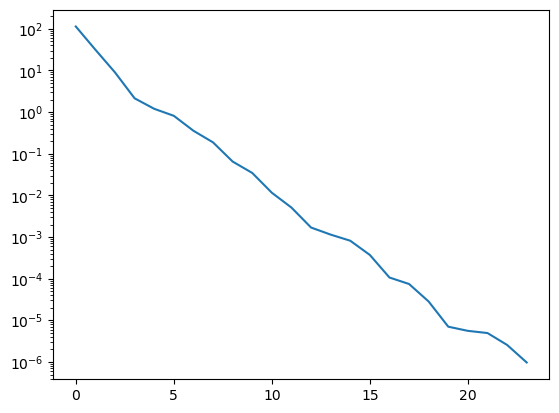

In [48]:
plt.semilogy(data["x_errs"])
plt.show()